#Set up the Code
    1- Download the Data
    2- Convert the Annotations into the YOLO v5 Format
    3- YOLO v5 Annotation Format
    4- Testing the annotations
    5- Partition the Dataset
    6- Training Options
    7- Data Config File
    8- Hyper-parameter Config File
    9- Custom Network Architecture
    10-Train the Model
    11-Inference
    12-Computing the mAP on test dataset

In [10]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import zipfile
random.seed(108)

In [7]:
# #In Google colab
# if not os.path.exists('yolov5'):
#     !git clone https://github.com/ultralytics/yolov5.git

In [11]:
import xml.etree.ElementTree as ET
import os

# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            info_dict['base_filename'] = os.path.basename(xml_file)  # Extract base filename

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)
            
        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict


In [3]:
extract_info_from_xml(r'annotations\pridemobility-duryea-quantum-wip-counting-backrack-1_20240215_063015-0.xml')

{'bboxes': [{'class': 'backrack',
   'xmin': 451,
   'ymin': 221,
   'xmax': 528,
   'ymax': 348},
  {'class': 'backrack', 'xmin': 550, 'ymin': 185, 'xmax': 619, 'ymax': 332},
  {'class': 'backrack', 'xmin': 632, 'ymin': 172, 'xmax': 714, 'ymax': 326},
  {'class': 'backrack', 'xmin': 748, 'ymin': 171, 'xmax': 834, 'ymax': 307},
  {'class': 'backrack', 'xmin': 1061, 'ymin': 164, 'xmax': 1115, 'ymax': 241},
  {'class': 'backrack', 'xmin': 1092, 'ymin': 155, 'xmax': 1138, 'ymax': 231},
  {'class': 'backrack', 'xmin': 1119, 'ymin': 151, 'xmax': 1164, 'ymax': 210},
  {'class': 'backrack', 'xmin': 1163, 'ymin': 163, 'xmax': 1201, 'ymax': 233},
  {'class': 'backrack', 'xmin': 1198, 'ymin': 157, 'xmax': 1218, 'ymax': 230},
  {'class': 'backrack', 'xmin': 1216, 'ymin': 160, 'xmax': 1229, 'ymax': 226},
  {'class': 'backrack', 'xmin': 1227, 'ymin': 166, 'xmax': 1241, 'ymax': 225},
  {'class': 'backrack', 'xmin': 1240, 'ymin': 172, 'xmax': 1252, 'ymax': 221},
  {'class': 'person', 'xmin': 337, 'ym

In [12]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"person": 0,
                           "backrack": 1,
                           "centermounts": 2
                           }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
            continue
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        #print(f'this is center', b_center_x)
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        #print(f'this is y', b_center_y)
        b_width    = (b["xmax"] - b["xmin"])
        #print(f'this is b_width', b_width)
        b_height   = (b["ymax"] - b["ymin"])
        #print(f'b_height', b_height)

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        #print(b_center_x)
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        p = print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        #print(p)
 
   
    # Name of the file which we have to save
    save_file_name = os.path.join("annotations", info_dict['base_filename'].replace("xml", "txt"))
    save_file_name
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

Number of annotation files: 14643
Image File: annotations\pridemobility-duryea-quantum-wip-counting-centermount-1_20240214_081918-2.txt
Number of files: 14643


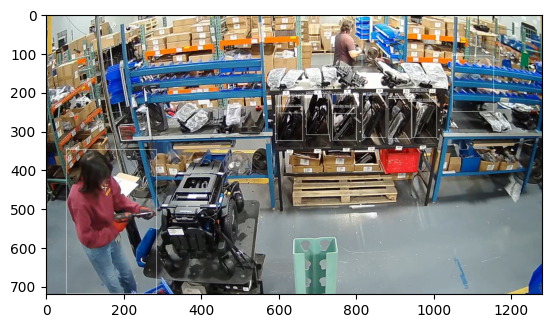

In [14]:
#For reproducible results used below random.seed(0)
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
# Print the length of the annotations list for debugging
print("Number of annotation files:", len(annotations))
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
print("Image File:", annotation_file)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
print("Number of files:", len(annotations))
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

#For 80%,10,10

In [18]:
# # Read images and annotations
# images = [os.path.join('images', x) for x in os.listdir('images')]
# annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
# print(len(images))
# print(len(annotations))
# images.sort()
# annotations.sort()

# # Split the dataset into train-valid-test splits
# train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
# val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


6304
6304


#For 70,20,10

In [15]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]
print(len(images))
print(len(annotations))
images.sort()
annotations.sort()
# Split the dataset into train-valid-test splits
train_images, remaining_images, train_annotations, remaining_annotations = train_test_split(images, annotations, test_size=0.3, random_state=1)
val_images, test_images, val_annotations, test_annotations = train_test_split(remaining_images, remaining_annotations, test_size=0.33, random_state=1)

14643
14643


In [8]:
import os

# Create directories for images
os.makedirs('images/train', exist_ok=True)
os.makedirs('images/val', exist_ok=True)
os.makedirs('images/test', exist_ok=True)

# Create directories for labels
os.makedirs('labels/train', exist_ok=True)
os.makedirs('labels/val', exist_ok=True)
os.makedirs('labels/test', exist_ok=True)


In [9]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val')
move_files_to_folder(test_images, 'images/test')
move_files_to_folder(train_annotations, 'labels/train')
move_files_to_folder(val_annotations, 'labels/val')
move_files_to_folder(test_annotations, 'labels/test')

# !mv annotations labels
# %cd ../

In [21]:
os.makedirs('Data', exist_ok=True)

In [23]:
# First, Data Config File creation
yaml_content = """
path: D:/Rabeea/Model_training_pride
train: images/train
val:  images/val
test: images/test

# number of classes
nc: 3

# class names
names: ["person","backrack","centermounts"]
"""

# Now, write the YAML content to a file
with open('Data/pride.yaml', 'w') as file:
    file.write(yaml_content)


In [24]:
# First, Hyperparameter Config File
yaml_content = """
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials


lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
copy_paste: 0.0  # image copy-paste (probability)
lrf: 0.2  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 1.0  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
"""

# Now, write the YAML content to a file
with open('Data/hyp.scratch.yaml', 'w') as file:
    file.write(yaml_content)

In [4]:
!python yolov5/train.py --img-size 640 --cfg yolov5/models/yolov5s.yaml --hyp Data/hyp.scratch.yaml --batch 32 --epochs 5 --data Data/pride.yaml --weights yolov5s.pt --workers 24 --name yolo_pride

In [ ]:
!python yolov5/detect.py --source images/test --weights yolov5/runs/train/yolo_pride/weights/best.pt --conf 0.25 --name yolo_pride

detect: weights=['/content/yolov5/runs/train/yoflo_road_det/weights/best.pt'], source=/content/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/88 /content/images/test/road100.png: 640x640 2 speedlimits, 17.9ms
image 2/88 /content/images/test/road113.png: 448x640 (no detections), 92.4ms
image 3/88 /content/images/test/road129.png: 448x640 (no detections), 8.6ms
image

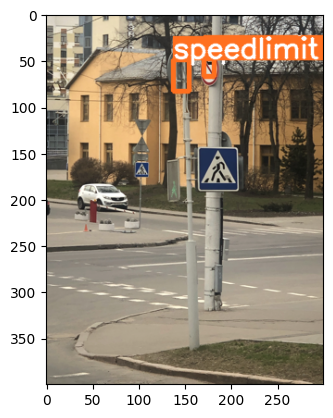

In [ ]:
detections_dir = "yolov5/runs/detect/yolo_pride"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
!python yolov5/val.py --weights /yolov5/runs/train/yoflo_road_det/weights/best.pt --data /content/Data/road_sign_data.yaml --task test --save-txt --save-hybrid --save-conf --name yolo_det

val: data=/content/Data/road_sign_data.yaml, weights=['/content/yolov5/runs/train/yoflo_road_det/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=True, save_conf=True, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
WARNING ⚠️ --save-hybrid will return high mAP from hybrid labels, not from predictions alone
YOLOv5 🚀 v7.0-294-gdb125a20 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/labels/test... 88 images, 0 backgrounds, 0 corrupt: 100% 88/88 [00:00<00:00, 864.91it/s]
test: New cache created: /content/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:09<00:00,  3.09s/it]
                   all   

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir /content/yolov5/runs/train/yolo_road_det

In [ ]:
monitor_tensorboard()